In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import seaborn as sns
import matplotlib
import networkx as nx
import matplotlib.gridspec as gridspec
from scipy.stats import ttest_ind, ttest_rel
import matplotlib
from utils.topology import identify_env_pairs_basis10_train_wo_subgraph
from utils.plot import smooth_mean_std

%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['ps.fonttype'] = 42
rcParams['font.sans-serif'] = ['Arial']  # 예시: Arial로 설정
rcParams['font.family'] = 'sans-serif'

sns.set_style(
    'ticks',
    rc={
        'xtick.direction': 'in',  # x축 tick을 안쪽으로
        'ytick.direction': 'in',  # y축 tick을 안쪽으로
    }
)
rcParams["figure.dpi"] = 600
# Set the font to Arial
big_font = 20
mid_font = 15
small_font = 12

indicator_font = big_font
legend_font = mid_font
title_font = mid_font
axis_font = mid_font
tick_font = small_font



subplot_scale_factor = 3

indicator_x_loc = -0.1
indicator_y_loc = 1.15

node_size = 300
edge_width = 4


In [2]:
junction_color = "#416788"
deadend_color = "#646464"
edge_color = "#E1DAD2"

palette = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']

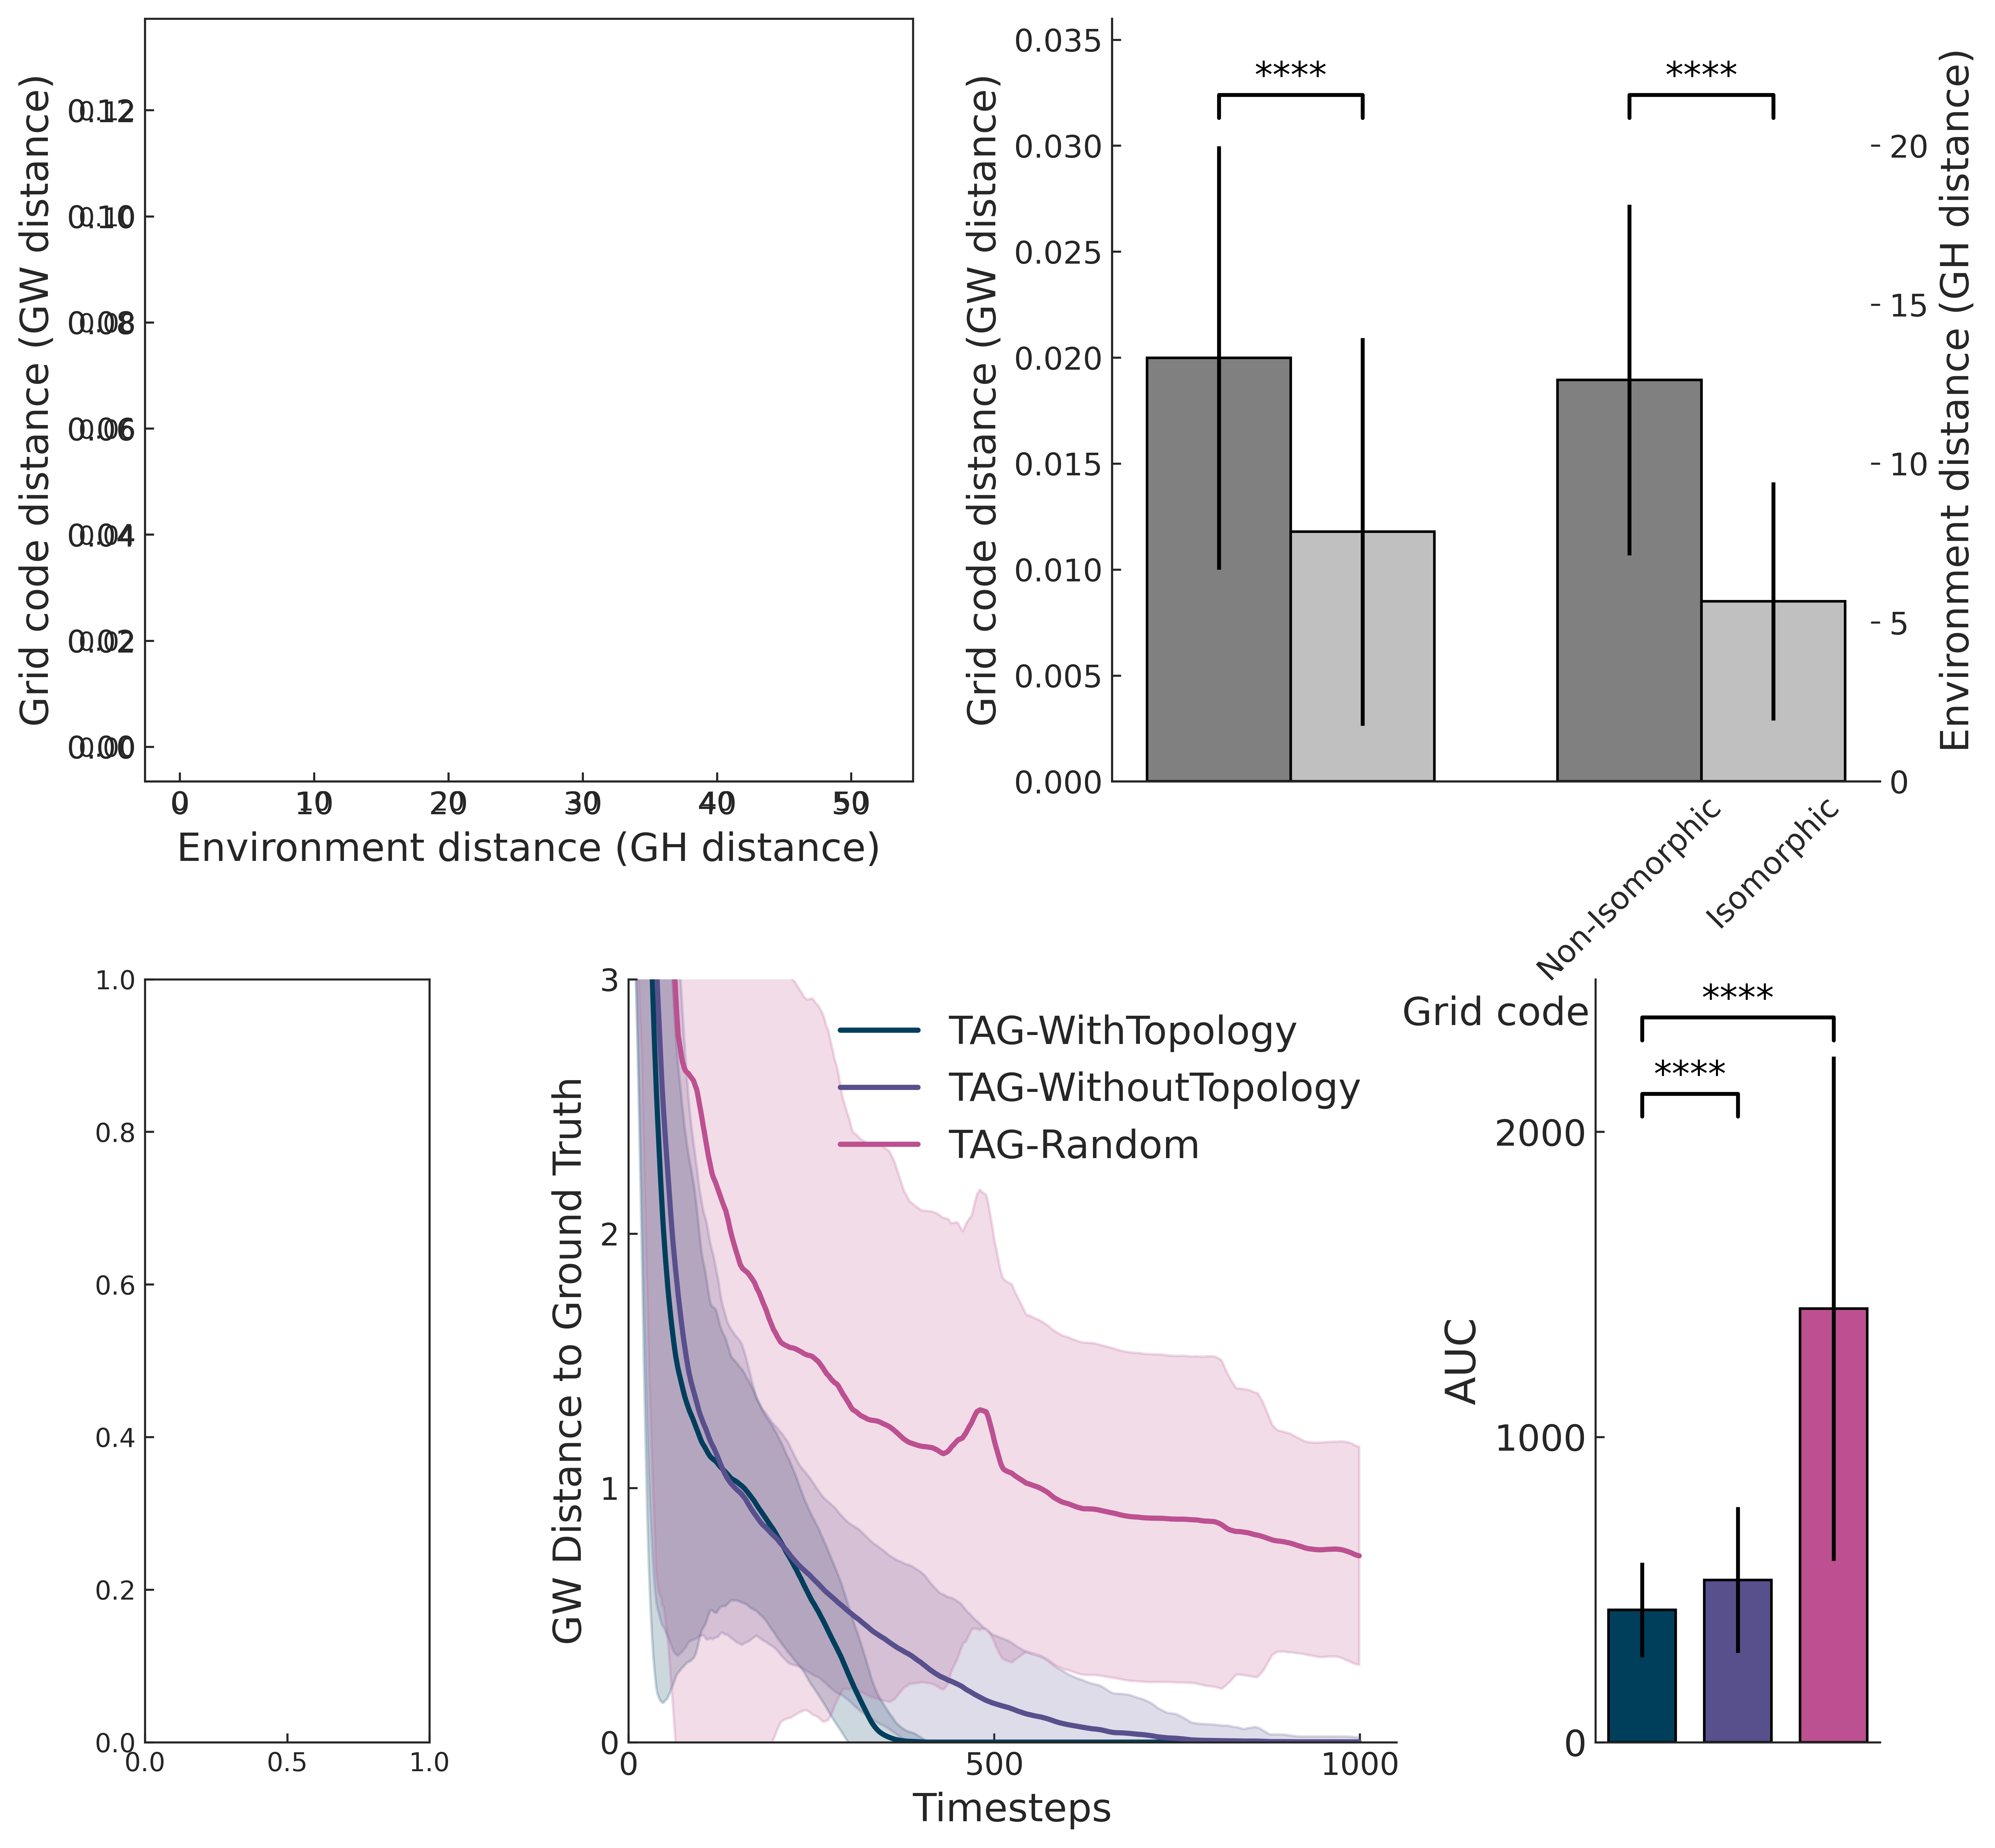

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

num_row, num_column = 4, 4
figsize_x = np.min([num_column * subplot_scale_factor, 20])
figsize_y = figsize_x * num_row / num_column
fig = plt.figure(figsize=(figsize_x, figsize_y))
gs = gridspec.GridSpec(num_row, num_column, figure=fig, height_ratios=[1 for _ in range(num_row)], width_ratios=[1  for _ in range(num_column)])

ax_scatter = fig.add_subplot(gs[0:2, 0:2])
ax_bar_grid = fig.add_subplot(gs[0:2, 2:4])
# ax_bar_por = fig.add_subplot(gs[0:2, 4])
ax_concept = fig.add_subplot(gs[2:4, 0])
ax_speed = fig.add_subplot(gs[2:4, 1:3])
ax_speed_auc = fig.add_subplot(gs[2:4, 3])

env_dist_mat = np.load('data/isomorphism_distinguish/gh_dist_graph_mat.npy')
env_dist_mat = (env_dist_mat + env_dist_mat.T) / 2
skel_grid_dist_mat = np.load("data/isomorphism_distinguish/skel_gw_dist_grid_mat.npy")
skel_grid_dist_mat = (skel_grid_dist_mat + skel_grid_dist_mat.T) / 2

for total_index in range(1000):
    ratio_index = total_index // 100 + 1
    index = total_index % 100 + 1
    G = nx.MultiGraph(
        nx.read_graphml(
            f"data/skeletonize/skeleton_graph/train/{ratio_index}_{index}.graphml"
        )
    )
    if G.number_of_nodes() == 1:
        env_dist_mat[total_index] = np.nan
        env_dist_mat[:, total_index] = np.nan
        skel_grid_dist_mat[total_index] = np.nan
        skel_grid_dist_mat[:, total_index] = np.nan


def get_sorted_indices(matrix):
    # Get the upper triangular part of the matrix, excluding the diagonal
    upper_tri_indices = np.triu_indices_from(matrix, k=1)

    # Extract the values from the upper triangular part
    upper_tri_values = matrix[upper_tri_indices]

    # Sort the values in descending order and get the sorted indices
    sorted_indices = np.argsort(-upper_tri_values)

    # Map the sorted indices back to the original row and column indices
    sorted_row_indices = upper_tri_indices[0][sorted_indices]
    sorted_col_indices = upper_tri_indices[1][sorted_indices]

    # Combine row and column indices into pairs
    sorted_pairs = list(zip(sorted_row_indices, sorted_col_indices))

    return sorted_pairs

def extract_and_filter_values(matrix_a, matrix_b, pairs):
    values_a = []
    values_b = []
    for row, col in pairs:
        value_a = matrix_a[row, col]
        value_b = matrix_b[row, col]
        if value_a >= 0 and value_b >= 0:
            values_a.append(value_a)
            values_b.append(value_b)
    return values_a, values_b


gh_sorted_pairs = get_sorted_indices(env_dist_mat)

env_values, skel_grid_values = extract_and_filter_values(
    env_dist_mat, skel_grid_dist_mat, gh_sorted_pairs
)



isomorphic_pairs, non_isomorphic_pairs = (
    identify_env_pairs_basis10_train_wo_subgraph(
        gh_sorted_pairs, env_dist_mat, skel_grid_dist_mat, skel_grid_dist_mat
    )
)

gh_isomorphic = [env_dist_mat[pair[0], pair[1]] for pair in isomorphic_pairs]
skel_gw_isomorphic = [skel_grid_dist_mat[pair[0], pair[1]] for pair in isomorphic_pairs]
gh_non_isomorphic = [env_dist_mat[pair[0], pair[1]] for pair in non_isomorphic_pairs]
skel_gw_non_isomorphic = [
    skel_grid_dist_mat[pair[0], pair[1]] for pair in non_isomorphic_pairs
]
# por_isomorphic = [por_dist_mat[pair[0], pair[1]] for pair in isomorphic_pairs]
# por_non_isomorphic = [por_dist_mat[pair[0], pair[1]] for pair in non_isomorphic_pairs]

# Perform t-tests
gh_ttest_in = ttest_ind(gh_isomorphic, gh_non_isomorphic)
skel_gw_ttest_in = ttest_ind(skel_gw_isomorphic, skel_gw_non_isomorphic)
# por_ttest_in = ttest_ind(por_isomorphic, por_non_isomorphic)

# Extract p-values
p_value_gh_in = gh_ttest_in.pvalue
p_value_skel_gw_in = skel_gw_ttest_in.pvalue
# p_value_por_in = por_ttest_in.pvalue

def get_significance_stars(p_value):
    if p_value < 0.0001:
        return "****"
    elif p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return "n.s."  # Not significant


gh_significance_in = get_significance_stars(p_value_gh_in)
skel_gw_significance_in = get_significance_stars(p_value_skel_gw_in)
# por_significance_in = get_significance_stars(p_value_por_in)


mean_gh_isomorphic = np.mean(gh_isomorphic)
mean_gh_non_isomorphic = np.mean(gh_non_isomorphic)
mean_skel_gw_isomorphic = np.mean(skel_gw_isomorphic)
mean_skel_gw_non_isomorphic = np.mean(skel_gw_non_isomorphic)
# mean_por_isomorphic = np.mean(por_isomorphic)
# mean_por_non_isomorphic = np.mean(por_non_isomorphic)


std_gh_isomorphic = np.std(gh_isomorphic)
std_gh_non_isomorphic = np.std(gh_non_isomorphic)
std_skel_gw_isomorphic = np.std(skel_gw_isomorphic)
std_skel_gw_non_isomorphic = np.std(skel_gw_non_isomorphic)
# std_por_isomorphic = np.std(por_isomorphic)
# std_por_non_isomorphic = np.std(por_non_isomorphic)

# Bar plot parameters
gh_means = [mean_gh_isomorphic, mean_gh_non_isomorphic]
gh_stds = [std_gh_isomorphic, std_gh_non_isomorphic]
skel_gw_means = [mean_skel_gw_isomorphic, mean_skel_gw_non_isomorphic]
skel_gw_stds = [std_skel_gw_isomorphic, std_skel_gw_non_isomorphic]
# por_means = [mean_por_isomorphic, mean_por_non_isomorphic]
# por_stds = [std_por_isomorphic, std_por_non_isomorphic]

width = 1  # the width of the bars

mult_fact = 1.2
env_values = np.array(env_values).reshape(-1, 1)
skel_grid_values = np.array(skel_grid_values).reshape(-1, 1)
# Fit the linear regression model
model = LinearRegression()
model.fit(env_values, skel_grid_values)

# Predict values for the regression line
predicted_values = model.predict(env_values)

# Bootstrap to estimate the confidence interval
n_bootstraps = 1000
bootstrapped_predictions = np.zeros((n_bootstraps, len(env_values)))

for i in range(n_bootstraps):
    # Resample the data
    env_resampled, skel_grid_resampled = resample(env_values, skel_grid_values)
    model.fit(env_resampled, skel_grid_resampled)
    bootstrapped_predictions[i] = model.predict(env_values).squeeze()

# Calculate the confidence interval
lower_bound = np.percentile(bootstrapped_predictions, 2.5, axis=0)
upper_bound = np.percentile(bootstrapped_predictions, 97.5, axis=0)

# Skel GW
ax_scatter.set_xlabel("Environment distance (GH distance)", fontsize=axis_font)
ax_scatter.set_ylabel("Grid code distance (GW distance)", fontsize=axis_font)
ax_scatter.scatter(
    gh_non_isomorphic,
    skel_gw_non_isomorphic,
    label="Non-Isomorphic",
    color="#808080",
    alpha=1,
)
ax_scatter.scatter(
    gh_isomorphic, skel_gw_isomorphic, label="Isomorphic", color="#C0C0C0", alpha=1, edgecolors="#C0C0C0"
)
ax_scatter.tick_params(axis='x', labelsize=tick_font)
ax_scatter.tick_params(axis='y', labelsize=tick_font)
ax_scatter.spines['top'].set_visible(False)
ax_scatter.spines['right'].set_visible(False)

# Plot the regression line
ax_scatter.plot(env_values, predicted_values, color="black", linewidth=3, label="Regression line")

# Plot the confidence interval
ax_scatter.fill_between(
    env_values.flatten(),
    lower_bound,
    upper_bound,
    color="red",
    alpha=0.2,
)

# ax_scatter.legend(fontsize=legend_font, frameon=False)

width = 0.35  # the width of the bars
# Plot GH distances on the primary y-axis
rects1 = ax_bar_grid.bar([-width/2, +width/2], skel_gw_means[::-1], width, yerr=skel_gw_stds[::-1], color=['#808080', '#C0C0C0'], edgecolor='black', capsize=0)
ax_bar_grid.set_ylabel("Grid code distance (GW distance)", fontsize=axis_font)
ax_bar_grid.tick_params(axis="y")
ax_bar_grid_ylim = 0.03 * mult_fact
ax_bar_grid.set_ylim(0, ax_bar_grid_ylim)

# Set x-ticks and labels
ax_bar_grid.set_xticks([-width/2, +width/2])  # Set numerical positions for the ticks
ax_bar_grid.set_xticklabels(['Non-Isomorphic', 'Isomorphic'])  # Set the labels for the ticks
ax_bar_grid.tick_params(axis='x', labelsize=tick_font, rotation=45)
ax_bar_grid.tick_params(axis='y', labelsize=tick_font)
ax_bar_grid.set_xlabel("Grid code", fontsize=axis_font)
ax_bar_grid.spines['top'].set_visible(False)
ax_bar_grid.spines['right'].set_visible(False)

# Add significance stars and p-values for gh
ax_bar_grid.text(0, ax_bar_grid_ylim * 0.9, skel_gw_significance_in, ha="center", va="bottom", color="black", fontsize=14)
ax_bar_grid.plot([-width/2, -width/2, width/2, width/2], [ax_bar_grid_ylim * 0.87, ax_bar_grid_ylim * 0.9, ax_bar_grid_ylim * 0.9, ax_bar_grid_ylim * 0.87], lw=1.5, color='k')


# Create a secondary y-axis for GW distances
ax_bar_env = ax_bar_grid.twinx()
rects2 = ax_bar_env.bar([1- width/2, 1+width/2], gh_means[::-1], width, yerr=gh_stds[::-1], color=['#808080', '#C0C0C0'], edgecolor='black', capsize=0)
ax_bar_env.set_xticks([1- width/2, 1+width/2])
ax_bar_env.set_xticklabels(['Non-Isomorphic', 'Isomorphic'])
ax_bar_env.set_xlabel("Environment", fontsize=axis_font)
ax_bar_env.set_ylabel("Environment distance (GH distance)", fontsize=axis_font)
ax_bar_env.tick_params(axis="x", labelsize=tick_font, rotation=45)
ax_bar_env.tick_params(axis="y", labelsize=tick_font)
ax_bar_env_ylim = 20 * mult_fact
ax_bar_env.set_ylim(0, ax_bar_env_ylim)
ax_bar_env.spines['top'].set_visible(False)
ax_bar_env.spines['right'].set_visible(False)


# Add significance stars and p-values for skel_gw
ax_bar_env.text(1, ax_bar_env_ylim * 0.9, gh_significance_in, ha="center", va="bottom", color="black", fontsize=14)
ax_bar_env.plot([1-width/2, 1-width/2, 1+width/2, 1+width/2], [ax_bar_env_ylim * 0.87, ax_bar_env_ylim * 0.9, ax_bar_env_ylim * 0.9, ax_bar_env_ylim * 0.87], lw=1.5, color='k')



color_order = [3, 0, 1, 4, 1]
colors_models = [plt.cm.tab10(color_order[i]) for i in range(5)]
labels = ['TAG-WithTopology', 'TAG-WithoutTopology', 'TAG-UCB', 'Least Sampled', 'TAG-Random']
for index, i in enumerate([0, 1, 4]):
    mean_data = np.load(f'data/exploration/{i}_means.npy')[:1000]
    std_data = np.load(f'data/exploration/{i}_stds.npy')[:1000]
    mean_data, std_data = smooth_mean_std(mean_data, std_data, 20)
    # Define the x-axis values (assuming they are indices of the data points)
    x_values = np.arange(len(mean_data))

    # Plot the mean data
    ax_speed.plot(x_values, mean_data, label=labels[i], color=palette[index], lw=2)

    # Fill between the mean ± standard deviation
    ax_speed.fill_between(x_values, mean_data - std_data, mean_data + std_data, color=palette[index], alpha=0.2)

# Add labels and title
ax_speed.set_xlabel('Timesteps', fontsize=axis_font)
ax_speed.set_ylabel('GW Distance to Ground Truth', fontsize=axis_font)
ax_speed.set_xticks([0, 500, 1000])
ax_speed.set_yticks([0, 1, 2, 3])
ax_speed.set_xticklabels([0, 500, 1000], fontsize=tick_font)
ax_speed.set_yticklabels([0, 1, 2, 3], fontsize=tick_font)
ax_speed.tick_params(axis='x', labelsize=tick_font)
ax_speed.tick_params(axis='y', labelsize=tick_font)
# plt.axhline(y=0.0, color='black', linestyle='-', label='Threshold')
ax_speed.set_xlim(0, 1050)
ax_speed.set_ylim(-0., 3)
ax_speed.legend(fontsize=legend_font, frameon=False)
ax_speed.spines['top'].set_visible(False)
ax_speed.spines['right'].set_visible(False)


# Function to get significance stars
def get_significance_stars(p_value):
    if p_value <= 0.0001:
        return "****"
    elif p_value <= 0.001:
        return "***"
    elif p_value <= 0.01:
        return "**"
    elif p_value <= 0.05:
        return "*"
    else:
        return "ns"  # Not significant


indices = [0, 1, 4]
auc_values_list = []
auc_mean_list = []
auc_std_list = []
for i in indices:
    auc_mean = np.load(
        f"data/exploration/{i}_auc_mean.npy"
    )
    auc_std = np.load(
        f"data/exploration/{i}_auc_std.npy"
    )
    auc_values = np.load(
        f"data/exploration/{i}_auc.npy"
    )
    auc_values_list.append(auc_values)
    auc_mean_list.append(auc_mean)
    auc_std_list.append(auc_std)

# Perform t-tests between the AUC values
_, p_value_01 = ttest_rel(auc_values_list[0], auc_values_list[1])
_, p_value_04 = ttest_rel(auc_values_list[0], auc_values_list[2])
_, p_value_14 = ttest_rel(auc_values_list[1], auc_values_list[2])

# Plotting
x = np.arange(len(indices))  # the label locations
width = 0.7  # the width of the bars


# Plot AUC values
rects = ax_speed_auc.bar(
    x,
    auc_mean_list,
    width,
    yerr=auc_std_list,
    color=palette[:3],
    edgecolor="black",
    capsize=0,
)
ax_speed_auc.set_ylabel("AUC", fontsize=16)
# ax.set_xticks(x)
# ax.set_xticklabels(labels, fontsize=14)
ax_ylim = 2500

ax_speed_auc.text(
    0.5,
    ax_ylim * 0.85,
    get_significance_stars(p_value_01),
    ha="center",
    va="bottom",
    color="black",
    fontsize=14,
)
ax_speed_auc.plot(
    [0, 0, 1, 1],
    [ax_ylim * 0.82, ax_ylim * 0.85, ax_ylim * 0.85, ax_ylim * 0.82],
    lw=1.5,
    color="k",
)

ax_speed_auc.text(
    1,
    ax_ylim * 0.95,
    get_significance_stars(p_value_04),
    ha="center",
    va="bottom",
    color="black",
    fontsize=14,
)
ax_speed_auc.plot(
    [0, 0, 2, 2],
    [ax_ylim * 0.92, ax_ylim * 0.95, ax_ylim * 0.95, ax_ylim * 0.92],
    lw=1.5,
    color="k",
)
ax_speed_auc.set_xticks([])
ax_speed_auc.tick_params(axis='x', length=0)
ax_speed_auc.set_yticks([0, 1000, 2000])
ax_speed_auc.set_yticklabels([0, 1000, 2000], fontsize=14)
ax_speed_auc.set_ylim(0, ax_ylim)
ax_speed_auc.spines['top'].set_visible(False)
ax_speed_auc.spines['right'].set_visible(False)
fig.subplots_adjust(wspace=0.7, hspace=0.7)
extent = ax_scatter.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig("./figure/ax_scatter.png", bbox_inches=extent, dpi=600)

# Temporarily remove ax_scatter from the figure
for artist in ax_scatter.collections:
    artist.remove()

# Save the entire figure as an SVG excluding ax_scatter
plt.savefig("./figure/figure_6.svg", bbox_inches="tight", transparent=True)
# Add ax_scatter back to the figure
fig.add_subplot(gs[0:2, 0:2], sharex=ax_scatter, sharey=ax_scatter)
plt.show()